<a href="https://colab.research.google.com/github/MoiseyT/Grass-detection/blob/main/%22Grass_Cover_CNN_Moiseev_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

SyntaxError: ignored

In [ ]:
!pip install --upgrade --no-cache-dir gdown
!gdown https://drive.google.com/uc?id=1aIPFCAGSD5AHZ-bRiPQLfHQVeqcff0u7&export=download
!gdown https://drive.google.com/uc?id=1ZsmznUeTMZ4_KzkfXCkh3eDiSbD06T2p&export=download

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0
Downloading...
From: https://drive.google.com/uc?id=1aIPFCAGSD5AHZ-bRiPQLfHQVeqcff0u7
To: /content/test.zip
100% 175M/175M [00:07<00:00, 24.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ZsmznUeTMZ4_KzkfXCkh3eDiSbD06T2p
To: /content/training.zip
100% 130M/130M [00:03<00:00, 38.4MB/s]


In [ ]:
!unzip training.zip
!unzip test.zip

Archive:  training.zip
  inflating: training/Grass.csv      
   creating: training/image/
  inflating: training/image/101_102 (1).jpg  
  inflating: training/image/101_102 (10).jpg  
  inflating: training/image/101_102 (100).jpg  
  inflating: training/image/101_102 (11).jpg  
  inflating: training/image/101_102 (12).jpg  
  inflating: training/image/101_102 (13).jpg  
  inflating: training/image/101_102 (14).jpg  
  inflating: training/image/101_102 (15).jpg  
  inflating: training/image/101_102 (16).jpg  
  inflating: training/image/101_102 (17).jpg  
  inflating: training/image/101_102 (18).jpg  
  inflating: training/image/101_102 (19).jpg  
  inflating: training/image/101_102 (2).jpg  
  inflating: training/image/101_102 (20).jpg  
  inflating: training/image/101_102 (21).jpg  
  inflating: training/image/101_102 (22).jpg  
  inflating: training/image/101_102 (23).jpg  
  inflating: training/image/101_102 (24).jpg  
  inflating: training/image/101_102 (25).jpg  
  inflating: train

In [ ]:
!ls training/image | wc -l
!ls test | wc -l

1500
26


In [ ]:
!pip install deepml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.9/143.9 KB 11.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import torch

seed = 7

np.random.seed(seed)
torch.random.manual_seed(seed)

In [ ]:
train_dir = 'training/image'
labels_file = 'training/Grass.csv'
test_dir = 'test'

In [ ]:
labels_df = pd.read_csv(labels_file, sep=';',encoding='latin1')
labels_df['Grass'] = labels_df['Grass'].astype(np.float32)
labels_df

,Number,Grass
0,2190_002 (1).jpg,2.0
1,2190_002 (2).jpg,5.0
2,2190_002 (3).jpg,0.0
3,2190_002 (4).jpg,5.0
4,2190_002 (5).jpg,15.0
...,...,...
1495,102_102 (96).jpg,0.0
1496,102_102 (97).jpg,0.0
1497,102_102 (98).jpg,0.0
1498,102_102 (99).jpg,0.0


In [ ]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(labels_df, random_state=seed)
train.shape, val.shape

((1125, 2), (375, 2))

In [ ]:
import torchvision
import deepml
from deepml.datasets import ImageDataFrameDataset
from deepml import constants

transforms = torchvision.transforms.Compose([
                                             torchvision.transforms.Resize((224,224)),
                                             torchvision.transforms.ToTensor(),
                                             torchvision.transforms.Normalize(mean=constants.IMAGENET_MEAN, std=constants.IMAGENET_STD, inplace=True),
                                             ])

In [ ]:
train_dataset = ImageDataFrameDataset(train, image_file_name_column='Number', target_columns='Grass',
                                          image_dir=train_dir, transforms=transforms)

val_dataset = ImageDataFrameDataset(val, image_file_name_column='Number', target_columns='Grass',
                                        image_dir=train_dir, transforms=transforms)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False)

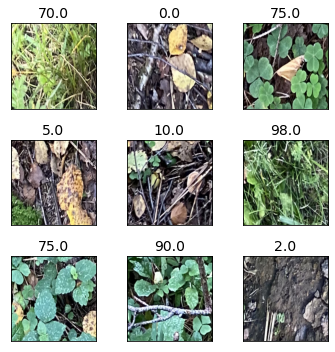

In [ ]:
from deepml.visualize import show_images_from_loader
from deepml.transforms import ImageNetInverseTransform

inverse_transform = ImageNetInverseTransform()

show_images_from_loader(val_loader, inverse_transform)

In [ ]:
model = torchvision.models.googlenet(pretrained=True)
#model = torchvision.models.resnext50_32x4d(pretrained=True)
# Modify for GoogLeNet
model.fc = torch.nn.Linear(in_features=1024, out_features=1, bias=True)
# Modify  for ResNet50
#model.fc = torch.nn.Linear(in_features=2048, out_features=1, bias=True)


Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

In [ ]:
from deepml.tasks import ImageRegression
from deepml.train import Learner
from deepml.losses import RMSELoss

work_dir = 'GoogLeNet'
regression = ImageRegression(model, work_dir)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = RMSELoss()

learner = Learner(regression, optimizer, criterion)

In [ ]:
from torch.nn import MSELoss

#metrics to evaluate
metrics = [("mse", MSELoss())]
learner.fit(train_loader, val_loader, epochs=1, image_inverse_transform=inverse_transform,
            metrics=metrics)

Epoch 1/1:


Training    :   0%|          | 0/141 [00:00<?, ?it/s]

Validation  :   0%|          | 0/47 [00:00<?, ?it/s]

Training Loss: 19.4519 Validation Loss: 13.0296 [Saving best validation model]


In [ ]:
#torch.save(model.state_dict(), '/content/drive/MyDrive/Grassdatainput/current_model.pt')

In [ ]:
#model.load_state_dict(torch.load('/content/drive/MyDrive/Grassdatainput/current_model.pt'))

NameError: ignored

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Grassdatainput/GooglNet_model.pt'))
#model.load_state_dict(torch.load('/content/drive/MyDrive/Grassdatainput/ResNet50.pt'))


<All keys matched successfully>

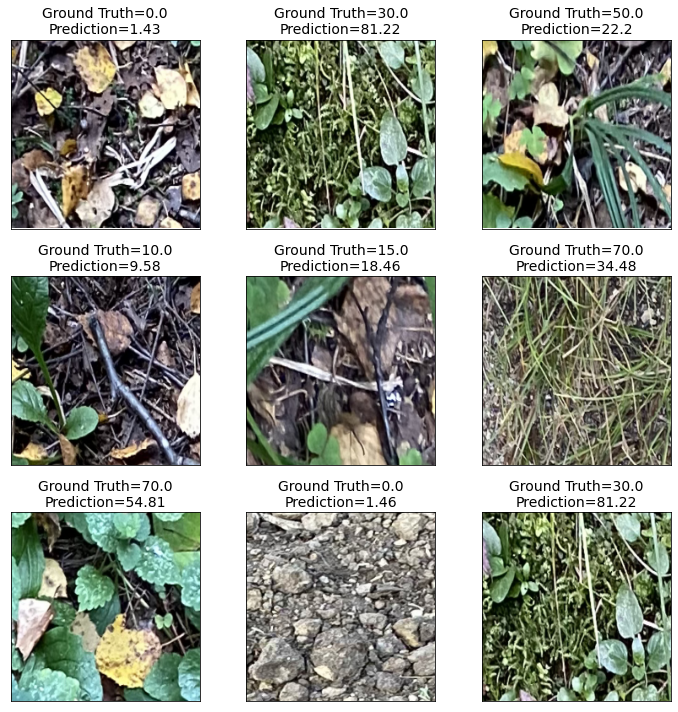

In [ ]:
learner.show_predictions(val_loader, image_inverse_transform=inverse_transform)

In [ ]:
!pip install image_slicer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 47.5 MB/s eta 0:00:00
  Attempting uninstall: Pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2


In [ ]:
from pathlib import Path
import image_slicer
import os
dirname = '/content/test'
files = os.listdir(dirname)
q = sorted(files)
pathlist = Path('/content/test').rglob('*.jpg')
for path in pathlist:
     path_in_str = str(path)
     tiles = image_slicer.slice(path_in_str, 100)
     os.remove(path_in_str)

In [ ]:
!ls test| wc -l

2600


In [ ]:
from deepml.datasets import ImageListDataset

test_dataset = ImageListDataset(test_dir, transforms)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, num_workers=4)
test_predictions, filenames = learner.predict(test_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Prediction  :   0%|          | 0/325 [00:00<?, ?it/s]

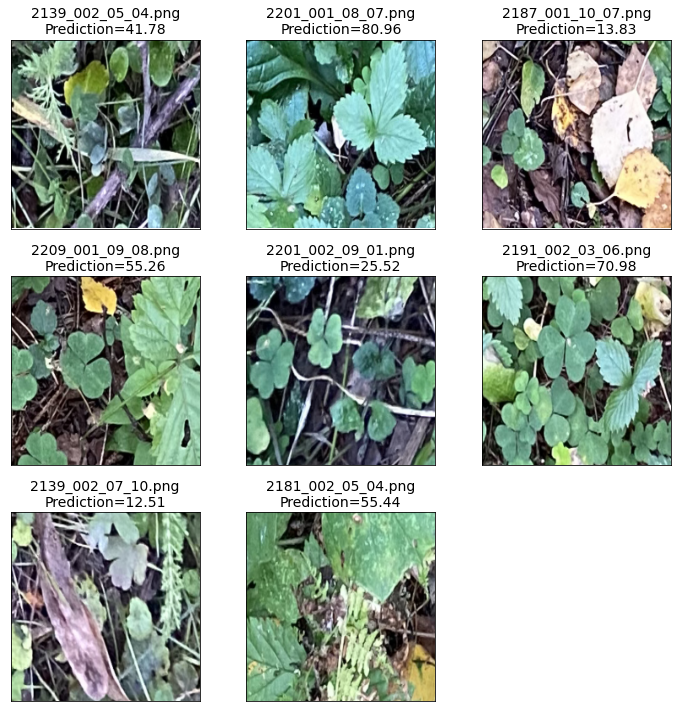

In [ ]:
learner.show_predictions(test_loader, target_known=False, image_inverse_transform=inverse_transform, samples=8)

In [ ]:
submission = pd.DataFrame(columns=['filename', 'Grass percent'])
submission['Grass percent'] = np.squeeze(test_predictions.numpy())
submission['filename'] = filenames
sorted_df = submission.sort_values(by='filename')
d = []
while sorted_df.count()[0] > 0:
  a = sorted_df.head(100)
  c = a["Grass percent"].mean()
  d.append(c)
  sorted_df = sorted_df.iloc[100:]
print(d)

[79.52944, 49.28844, 71.83912, 60.30166, 58.15862, 50.717667, 41.23699, 40.851463, 53.32847, 51.361595, 57.017036, 55.540443, 46.907833, 31.927214, 25.914951, 43.091988, 38.182976, 8.760061, 53.634434, 53.301292, 66.21865, 71.70903, 45.680244, 69.127495, 59.136982, 43.788715]


In [ ]:
pd.Series(d, index=q)

2139_001.jpg    79.529442
2139_002.jpg    49.288441
2150_001.jpg    71.839119
2150_002.jpg    60.301659
2151_001.jpg    58.158619
2151_002.jpg    50.717667
2177_001.jpg    41.236992
2177_002.jpg    40.851463
2181_001.jpg    53.328468
2181_002.jpg    51.361595
2183_002.jpg    57.017036
2186_001.jpg    55.540443
2186_002.jpg    46.907833
2187_001.jpg    31.927214
2187_002.jpg    25.914951
2188_001.jpg    43.091988
2188_002.jpg    38.182976
2190_001.jpg     8.760061
2191_001.jpg    53.634434
2191_002.jpg    53.301292
2192_001.jpg    66.218651
2192_002.jpg    71.709030
2193_002.jpg    45.680244
2201_001.jpg    69.127495
2201_002.jpg    59.136982
2209_001.jpg    43.788715
dtype: float32

In [ ]:
final = pd.DataFrame(columns=['filename', 'Grass percent'])
final['Grass percent'] = d
final['filename'] = q

In [ ]:
final.to_csv('/content/drive/MyDrive/Grassdatainput/final.csv', index=False)